In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
pd.pandas.set_option('display.max_columns',None)
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

## Loading Data

In [2]:
rating = pd.read_csv('BX-Book-Ratings.csv', encoding='latin-1', on_bad_lines='warn',sep=';')
book = pd.read_csv('BX-Books.csv', encoding='latin-1', on_bad_lines='warn',sep=';')
#user = pd.read_csv('BX-Users.csv', encoding='latin-1', on_bad_lines='warn',sep=';')

Skipping line 6452: expected 8 fields, saw 9
Skipping line 43667: expected 8 fields, saw 10
Skipping line 51751: expected 8 fields, saw 9

Skipping line 92038: expected 8 fields, saw 9
Skipping line 104319: expected 8 fields, saw 9
Skipping line 121768: expected 8 fields, saw 9

Skipping line 144058: expected 8 fields, saw 9
Skipping line 150789: expected 8 fields, saw 9
Skipping line 157128: expected 8 fields, saw 9
Skipping line 180189: expected 8 fields, saw 9
Skipping line 185738: expected 8 fields, saw 9

Skipping line 209388: expected 8 fields, saw 9
Skipping line 220626: expected 8 fields, saw 9
Skipping line 227933: expected 8 fields, saw 11
Skipping line 228957: expected 8 fields, saw 10
Skipping line 245933: expected 8 fields, saw 9
Skipping line 251296: expected 8 fields, saw 9
Skipping line 259941: expected 8 fields, saw 9
Skipping line 261529: expected 8 fields, saw 9

C:\Users\risha\AppData\Local\Temp\ipykernel_2404\1846637563.py:2: DtypeWarning: Columns (3) have mixed ty

In [3]:
book.head(2)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...


In [4]:
rating.head(2)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5


In [5]:
print("Books:",book.shape)
#print("Users:",user.shape)
print("Ratings:",rating.shape)

Books: (271360, 8)
Ratings: (1149780, 3)


# Data Preprocessing

In [6]:
book.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [7]:
rating.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [8]:
book = book[['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-L']]

URLs linking to cover images are also given, appearing in three different flavours (Image-URL-S, Image-URL-M, Image-URL-L), i.e., small, medium, large

### Handling Missing Values

In [9]:
book[book['Book-Author'].isnull()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
118033,0751352497,A+ Quiz Masters:01 Earth,NaN,1999,Dorling Kindersley,http://images.amazon.com/images/P/0751352497.0...
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing,http://images.amazon.com/images/P/9627982032.0...


After some google searches, we find that the author of the book 'The Credit Suisse Guide to Managing Your Personal Wealth' is:
<b>
Downes, Larissa Ann<b>e

In [10]:
book.at[187689, 'Book-Author'] = 'Downes, Larissa Anne'

In [11]:
book[book['Publisher'].isnull()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN,http://images.amazon.com/images/P/193169656X.0...
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN,http://images.amazon.com/images/P/1931696993.0...


The Publisher of both the book was 'NovelBooks, Incorporated', here is link if you want to check<br>
[Tyrant Moon](https://books.google.co.in/books/about/Tyrant_Moon.html?id=RSwAvp1VOe8C&source=kp_book_description&redir_esc=y) <br>
[Finders Keepers](https://books.google.co.in/books?id=M9pbPgAACAAJ&source=gbs_book_other_versions&redir_esc=y)

In [12]:
book.at[128890, 'Publisher'] = 'Mundania Press'
book.at[129037, 'Publisher'] = 'NovelBooks, Incorporated'

In [13]:
book[book['Image-URL-L'].isnull()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,NaN
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,NaN


The values are mismatched: the book title and author names are mixed up. For instance, the title should be "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)" and the author should be "James Buckley". Since 209538 is the same book as 221678, just with "Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)" written by the authors "James Buckley" and "Michael Teitelbaum". For verification use this [link](https://books.google.co.in/books/about/Creating_the_X_men.html?id=GKF6Rc0mgNgC&redir_esc=y). 

In [14]:
book.at[209538, 'Book-Title'] ='Creating the X-Men, How Comic Books Come to Life (Level 4)'
book.at[209538, 'Book-Author'] = 'James Buckley,Michael Teitelbaum'
book.at[209538, 'Year-Of-Publication'] = '2000'
book.at[209538, 'Publisher'] = 'DK Publishing Inc'
book.at[209538, 'Image-URL-L'] = 'http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg'

In [15]:
book[book['ISBN']=='078946697X'].values.tolist()

[['078946697X',
  'Creating the X-Men, How Comic Books Come to Life (Level 4)',
  'James Buckley,Michael Teitelbaum',
  '2000',
  'DK Publishing Inc',
  'http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg']]

In [16]:
book.at[220731, 'Book-Title'] ='Peuple du ciel, suivi de'
book.at[220731, 'Book-Author'] = 'Jean-Marie Gustave Le Clézio'
book.at[220731, 'Year-Of-Publication'] = '2003'
book.at[220731, 'Publisher'] = 'Gallimard'
book.at[220731, 'Image-URL-L'] = 'http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg'

In [17]:
book.at[3543, 'Year-Of-Publication']=1986

In [18]:
book[book['ISBN']=='2070426769'].values.tolist()

[['2070426769',
  'Peuple du ciel, suivi de',
  'Jean-Marie Gustave Le Clézio',
  '2003',
  'Gallimard',
  'http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg']]

### Drop the remaining missing values 

In [19]:
# Dropping the row at index 220731 since it's a duplicate book book with same author
book = book.drop(index=221678)
book = book.drop(index=118033)

In [20]:
book.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-L            0
dtype: int64

In [21]:
book.shape

(271358, 6)

# EDA
### Checking Columns for Mistakes in Data
#### Book-Author

In [22]:
book['Book-Author'].value_counts().head(15)

Book-Author
Agatha Christie         632
William Shakespeare     567
Stephen King            524
Ann M. Martin           423
Carolyn Keene           373
Francine Pascal         372
Isaac Asimov            330
Nora Roberts            315
Barbara Cartland        307
Charles Dickens         302
Not Applicable (Na )    286
R. L. Stine             282
Mark Twain              231
Jane Austen             223
Terry Pratchett         220
Name: count, dtype: int64

There are lot of books with no author name

#### Book Author containing Symbol (>)

In [23]:
book[book['Book-Author'].str.contains(r'>', regex=True, na=False)]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
15404,2070567842,Folio Junior: L'histoire De Monsieur Sommer,Su>skind-Sempe,0,Gallimard-Jeunesse,http://images.amazon.com/images/P/2070567842.0...
52778,3423705000,DTV Junior: Emil Und Die Detektive,Ka>stner,0,Deutscher Taschenbuch Verlag (DTV),http://images.amazon.com/images/P/3423705000.0...


In [24]:
book.at[52778, 'Book-Author']='Erich Kästner'
book.at[52778, 'Year-Of-Publication']=1991

In [25]:
book[book['Book-Author'].str.contains(r'@', regex=True, na=False)]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
163148,1580080707,Cybercafes: A Worldwide Guide for Travelers,cyberkath@traveltales.com,1999,Ten Speed Press,http://images.amazon.com/images/P/1580080707.0...


In [26]:
book.at[163148, 'Book-Author']='Cyberkath Traveltales'

#### Book Author containing only 2 letters

In [27]:
book[book['Book-Author'].str.match(r'^[a-zA-Z]{2}$', na=False)]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
28171,0395556376,Fate: New Poems,Ai,1991,Houghton Mifflin,http://images.amazon.com/images/P/0395556376.0...
75343,0380018853,Complete Runner,Ed,1983,Avon Books,http://images.amazon.com/images/P/0380018853.0...
104544,0060977612,God Is My Broker: A Monk-Tycoon Reveals the 7 ...,Ty,1999,Perennial,http://images.amazon.com/images/P/0060977612.0...
108819,0786834617,"Annette Mysteries, The - Box Set of 4 (Walt Di...",tk,2003,Disney Press,http://images.amazon.com/images/P/0786834617.0...
116382,0888888880,The Circle,Na,1999,Not Avail,http://images.amazon.com/images/P/0888888880.0...
123695,0786845848,The Lizzie McGuire Movie: Jr. Novel,tk,2003,Disney Press,http://images.amazon.com/images/P/0786845848.0...
130250,0590541781,Little Theme (My First Library),Na,1995,Scholastic,http://images.amazon.com/images/P/0590541781.0...
154042,0889627657,Wild Things Live Here: The Best of Northern Fr...,Na,2002,Mosaic Press,http://images.amazon.com/images/P/0889627657.0...
159340,3499430916,"Blut Will Der Damon (Fiction, Poetry and Drama)",Ky,0,Rowohlt Taschenbuch Verlag GmbH,http://images.amazon.com/images/P/3499430916.0...
166826,349920360X,HeiÃ?Â?t du wirklich Hassan Schmidt? Ein Krimi...,ky,1997,Rowohlt Tb.,http://images.amazon.com/images/P/349920360X.0...


In [28]:
#Fate: New Poems
book.at[28171, 'Book-Author']='Al Ogawa'
#Complete Runner
book.at[75343, 'Book-Author']="Runner's World Magazine"
#God Is My Broker: A Monk-Tycoon Reveals the 7 1/2 Laws of Spiritual and Financial Growth
book.at[104544, 'Book-Author']='Christopher Buckley and John Tierney'
#Annette Mysteries, The - Box Set of 4 (Walt Disney Presents)
book.at[108819	, 'Book-Title'] ="The Annette Mysteries collectionsr"
book.at[108819	, 'Book-Author'] ="Doris Schroeder"
#The Lizzie McGuire Movie: Jr. Novel
book.at[123695	, 'Book-Author'] ="david cody weiss"
#book=book.drop(130250)
#Wild Things Live Here: The Best of Northern Frights
book.at[154042, 'Book-Author']='Don Hutchison'
#Blut Will Der Damon (Fiction, Poetry and Drama)
book.at[159340, 'Book-Author']='Horst Bosetzky'
book.at[159340, 'Year-Of-Publication']=1993
#HeiÃ?Â?t du wirklich Hassan Schmidt? Ein Krimi. ( Ab 13 J.).'	
book.at[166826, 'Book-Author']='Horst Bosetzky'
book.at[166826, 'Book-Title']="Heißt du wirklich Hasan Schmidt?"
#Bh New Cookbook
book.at[191218, 'Book-Author']='Better Homes and Gardens'
book.at[191218, 'Book-Title']="Better Homes and Gardens New Cook Book"
book = book.drop(197735)
book = book.drop(203968)
book.at[219235, 'Year-Of-Publication']=1989
#Walt Disney's Santa's Toy Shop : Walt Disney Classic Edition (Walt Disney Classics (Hardcover))
book.at[243506	, 'Book-Title'] ="Walt Disney's Santa's Toy Shop"
book.at[243506	, 'Book-Author'] ="Al Dempster"
#Deutsche Gedichte
book.at[256126, 'Book-Author']="Paul Fleming, Volker Meid"
#Bh Crockery Cookery
book.at[261900, 'Book-Author']='Better Homes and Gardens'
book.at[261900, 'Book-Title']="Crockery Cooking (Better Homes and Gardens)"
#Easy Style Decorating Shortcuts
book.at[263394, 'Book-Author']='Better Homes and Gardens'

#### 4 books with 'Book-Author' name as x x

In [29]:
book[book['Book-Author']=='x x']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
149212,1591050367,An American Redneck in Hong Kong,x x,2002,"NovelBooks, Inc.",http://images.amazon.com/images/P/1591050367.0...
207132,1931696837,Unlawful,x x,2002,"NovelBooks, Inc.",http://images.amazon.com/images/P/1931696837.0...
212941,1591050804,Winter Fire,x x,2002,"NovelBooks, Inc.",http://images.amazon.com/images/P/1591050804.0...
234548,1931696810,Mating Season,x x,2002,"NovelBooks, Inc.",http://images.amazon.com/images/P/1931696810.0...


In [30]:
book.at[149212	, 'Book-Author'] ="Michael LaRocca"
book.at[207132	, 'Book-Author'] ="Dorice Nelson"
book.at[212941	, 'Book-Author'] ="Kathy Fischer-Brown"
book.at[234548	, 'Book-Author'] ="Liz Hunter"

#### 2 books with 'Book-Author' name is unknown

In [31]:
book[book['Book-Author']=='unknown']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
96703,1561449164,Pound It (Popular Mechanics for Kids),unknown,1997,Modern Publishing,http://images.amazon.com/images/P/1561449164.0...
267861,0960638822,A Course In Miracles Workbook for students Man...,unknown,1985,Foundation For Inner Peace,http://images.amazon.com/images/P/0960638822.0...


In [32]:
book.at[267861	, 'Book-Title'] ='A Course In Miracles Workbook for students Manual for Teachers'
book.at[267861	, 'Book-Author'] ="Helen Schucman"
book = book.drop(96703)

'Pound It (Popular Mechanics for Kids)', It's a toy & book in one there is no author

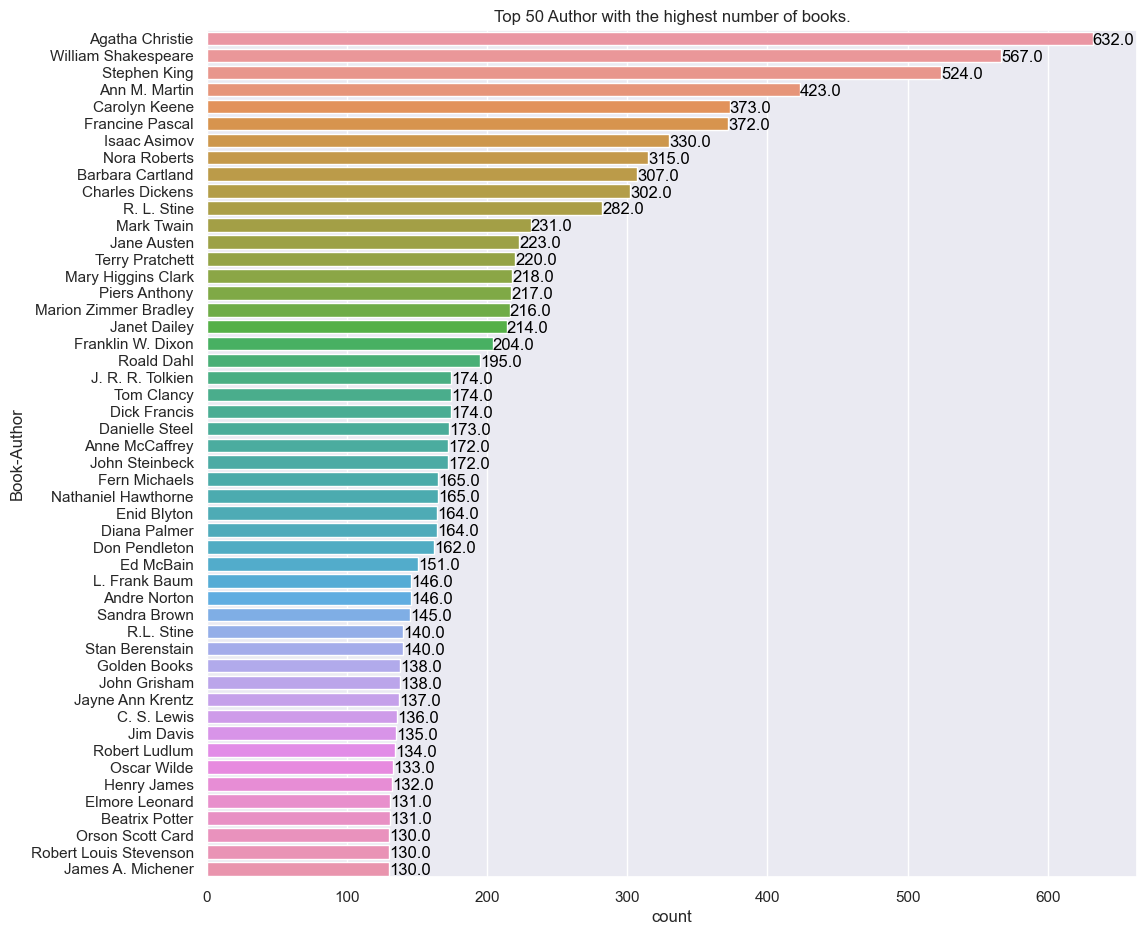

In [33]:
top_authors = book[book['Book-Author'] != 'Not Applicable (Na )']['Book-Author'].value_counts().head(50).index

sns.set(style='darkgrid')
plt.figure(figsize=(12,11))

# Create a barplot of Average-Rating vs Book-Title
ax = sns.countplot(y='Book-Author', data=book[book['Book-Author'].isin(top_authors)], order=top_authors)

# Add labels to each bar (Average-Rating values)
for i in ax.patches:
    ax.text(i.get_width() + 0.05, i.get_y() + 0.5, f'{i.get_width():.1f}', 
            fontsize=12, color='black', va='center')

plt.title('Top 50 Author with the highest number of books.')
plt.show()

### Publisher

In [34]:
book['Publisher'].value_counts().head(20)

Publisher
Harlequin                   7535
Silhouette                  4220
Pocket                      3905
Ballantine Books            3783
Bantam Books                3646
Scholastic                  3160
Simon &amp; Schuster        2971
Penguin Books               2844
Berkley Publishing Group    2771
Warner Books                2727
Penguin USA                 2717
Harpercollins               2525
Fawcett Books               2258
Signet Book                 2070
Random House Inc            2045
St Martins Pr               1953
St. Martin's Press          1783
Tor Books                   1704
HarperCollins Publishers    1700
Zebra Books                 1694
Name: count, dtype: int64

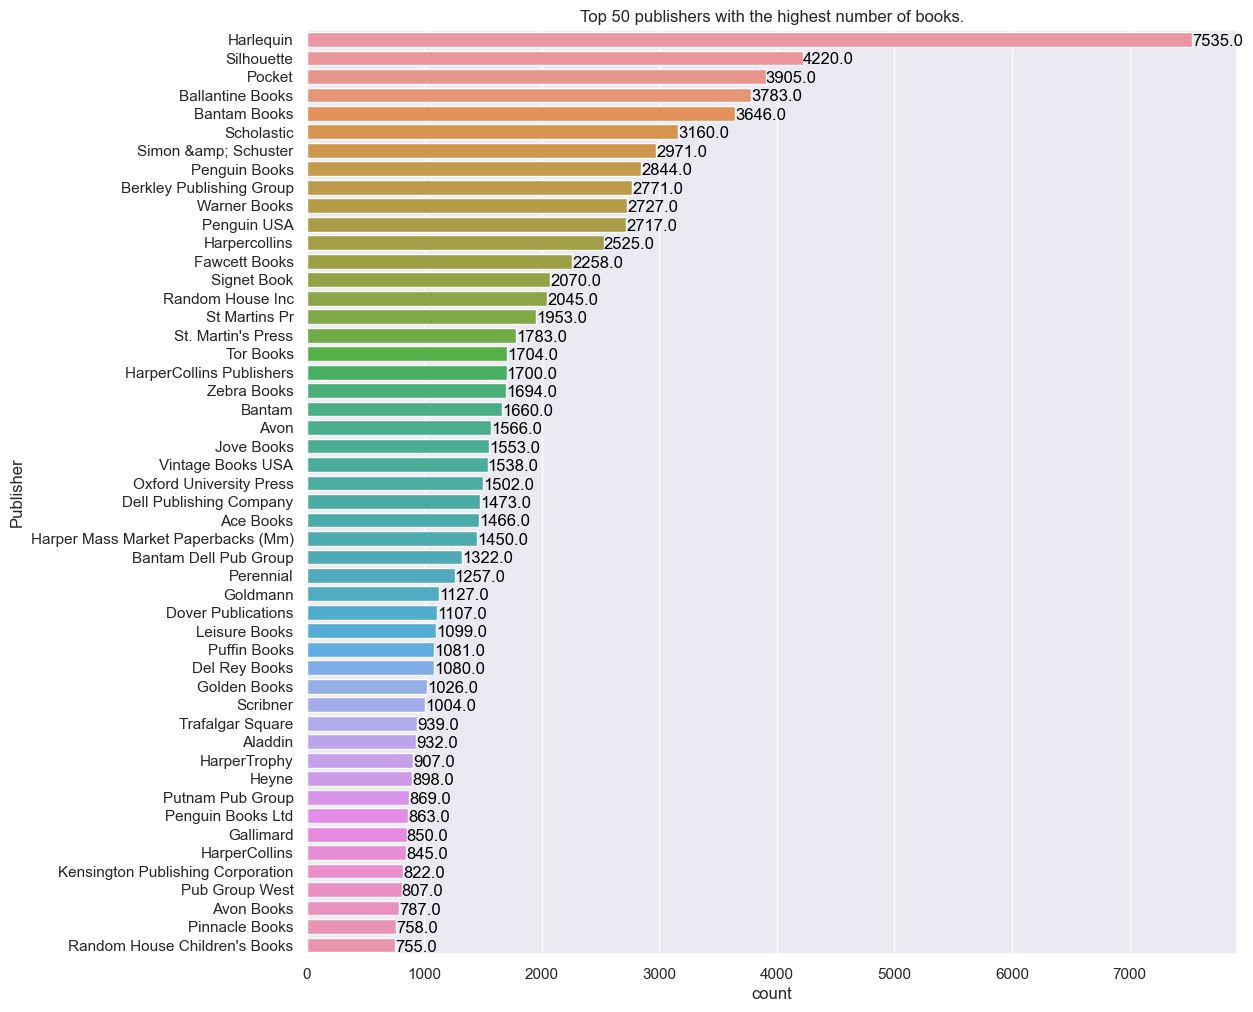

In [35]:
top_Publisher=book['Publisher'].value_counts().head(50).index
# Set a different style and color palette
sns.set(style='darkgrid')
plt.figure(figsize=(12,12))

# Create a barplot of Average-Rating vs Book-Title
ax = sns.countplot(y='Publisher', data=book[book['Publisher'].isin(top_Publisher)], order=top_Publisher)

# Add labels to each bar (Average-Rating values)
for i in ax.patches:
    ax.text(i.get_width() + 0.05, i.get_y() + 0.5, f'{i.get_width():.1f}', 
            fontsize=12, color='black', va='center')

plt.title('Top 50 publishers with the highest number of books.')
plt.show()

### Year-Of-Publication

In [36]:
book['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

There are a few values showing the year of publication as more than 2024, which is not possible.

In [37]:
book = book.copy()
book['Year-Of-Publication']=book['Year-Of-Publication'].astype('int64')

In [38]:
book['Year-Of-Publication'].value_counts().sort_index(ascending=False).head(10)

Year-Of-Publication
2050    2
2038    1
2037    1
2030    7
2026    1
2024    1
2021    1
2020    3
2012    1
2011    2
Name: count, dtype: int64

In [39]:
book['Year-Of-Publication'].value_counts().sort_index(ascending=True).head(10)

Year-Of-Publication
0       4614
1376       1
1378       1
1806       1
1897       1
1900       3
1901       7
1902       2
1904       1
1906       1
Name: count, dtype: int64

In [40]:
book[book['Year-Of-Publication']>2010][['ISBN','Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
12782,0380816792,A Rose in Winter,Kathleen E. Woodiwiss,2011,Harper Mass Market Paperbacks
30010,068160204X,The Royals,Kitty Kelley,2020,Bausch &amp; Lombard
37487,0671746103,MY TEACHER FRIED MY BRAINS (RACK SIZE) (MY TEA...,Coville,2030,Aladdin
55676,0671791990,MY TEACHER FLUNKED THE PLANET (RACK SIZE) (MY ...,Bruce Coville,2030,Aladdin
78168,0870449842,Crossing America,National Geographic Society,2030,National Geographic
80264,0140301690,Alice's Adventures in Wonderland and Through t...,Lewis Carroll,2050,Puffin Books
92156,068107468X,Edgar Allen Poe Collected Poems,Edgar Allan Poe,2020,Bausch &amp; Lombard
97826,0140201092,Outline of European Architecture (Pelican S.),Nikolaus Pevsner,2050,Penguin USA
116053,0394701658,Three Plays of Eugene Oneill,Eugene O'Neill,2038,Vintage Books USA
118294,3442436893,Das groÃ?Â?e BÃ?Â¶se- MÃ?Â¤dchen- Lesebuch.,Kathy Lette,2026,Goldmann


In [41]:
#In Our Time: Stories (Scribner Classic)
book.at[240169, 'Year-Of-Publication'] =1958
#CLOUT
book.at[246842, 'Year-Of-Publication'] =1995
#Monkey (An Evergreen Book, E-112)
book.at[235425, 'Year-Of-Publication'] =1943
#FOOTBALL SUPER TEAMS : FOOTBALL SUPER TEAMS
book.at[260974, 'Year-Of-Publication'] =1991
#To Have and Have Not
book.at[255409, 'Year-Of-Publication'] =1991
book.at[255409, 'Publisher'] ="Charles Scribner's Sons"
#Outline of European Architecture (Pelican S.)
book.at[97826, 'Year-Of-Publication'] =1990
#Owl's Amazing but True No. 2	
book.at[199196, 'Year-Of-Publication'] =1983
book.at[199196, 'Book-Author'] ='Laima Dingwall'
book.at[199196, 'Publisher'] ="Western Publishing Company"
#FOREST PEOPLE (Touchstone Books (Hardcover))	
book.at[228173, 'Year-Of-Publication'] =1987
book.at[228173, 'Book-Title'] ='The Forest People'
book.at[228173, 'Publisher'] ="Touchstone"
#Field Guide to the Birds of North America, 3rd Ed
book.at[192993, 'Year-Of-Publication'] =1999
#Das groÃ?Â?e BÃ?Â¶se- MÃ?Â¤dchen- Lesebuch.
book.at[118294, 'Year-Of-Publication'] =2006
book.at[118294, 'Book-Title'] ='Das große Böse- Mädchen- Lesebuch'
#Three Plays of Eugene Oneill
book.at[116053, 'Year-Of-Publication'] =1995
book.at[116053, 'Publisher'] ="Vintage Books"
#Alice's Adventures in Wonderland and Through the Looking Glass (Puffin Books)
book.at[80264, 'Year-Of-Publication'] =2003
book.at[80264, 'Publisher'] ="Penguin Books"
#Crossing America
book.at[78168, 'Year-Of-Publication'] =1999
#MY TEACHER FLUNKED THE PLANET (RACK SIZE) (MY TEACHER BOOKS)
book.at[55676, 'Year-Of-Publication'] =1992
#The Royals
book.at[30010, 'Year-Of-Publication'] =1998
book.at[30010, 'Publisher'] ="Hachette Book Group USA"
#'MY TEACHER FRIED MY BRAINS (RACK SIZE) (MY TEACHER BOOKS)
book.at[37487, 'Year-Of-Publication'] =1991
book.at[37487, 'Book-Author'] =' Bruce Coville'
#Edgar Allen Poe Collected Poems
book.at[92156, 'Year-Of-Publication'] =2013
book.at[92156, 'Book-Title'] ='The Poems of Edgar Allan Poe'
book.at[92156, 'Publisher'] ="Courier Corporation"

In [42]:
book[(book['Year-Of-Publication']<1900)&(book['Year-Of-Publication']>0)]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
171817,0781228956,"Complete Works 10 Volumes [2,6,7,8,9] (Notable...",Benjamin Franklin,1806,Reprint Services Corp,http://images.amazon.com/images/P/0781228956.0...
227531,9643112136,Dalan-i bihisht (Dastan-i Irani),Nazi Safavi,1378,Intisharat-i Quqnus,http://images.amazon.com/images/P/9643112136.0...
245607,0781268001,"Hugh Wynne, Free Quaker (2 Volumes (BCL1-PS Am...",Silas Weir Mitchell,1897,Reprint Services Corp,http://images.amazon.com/images/P/0781268001.0...
253750,964442011X,Tasht-i khun,IsmaÂ°il Fasih,1376,Nashr-i Alburz,http://images.amazon.com/images/P/964442011X.0...


In [43]:
#Dalan-i bihisht (Dastan-i Irani)
book.at[227531	, 'Year-Of-Publication'] =2010

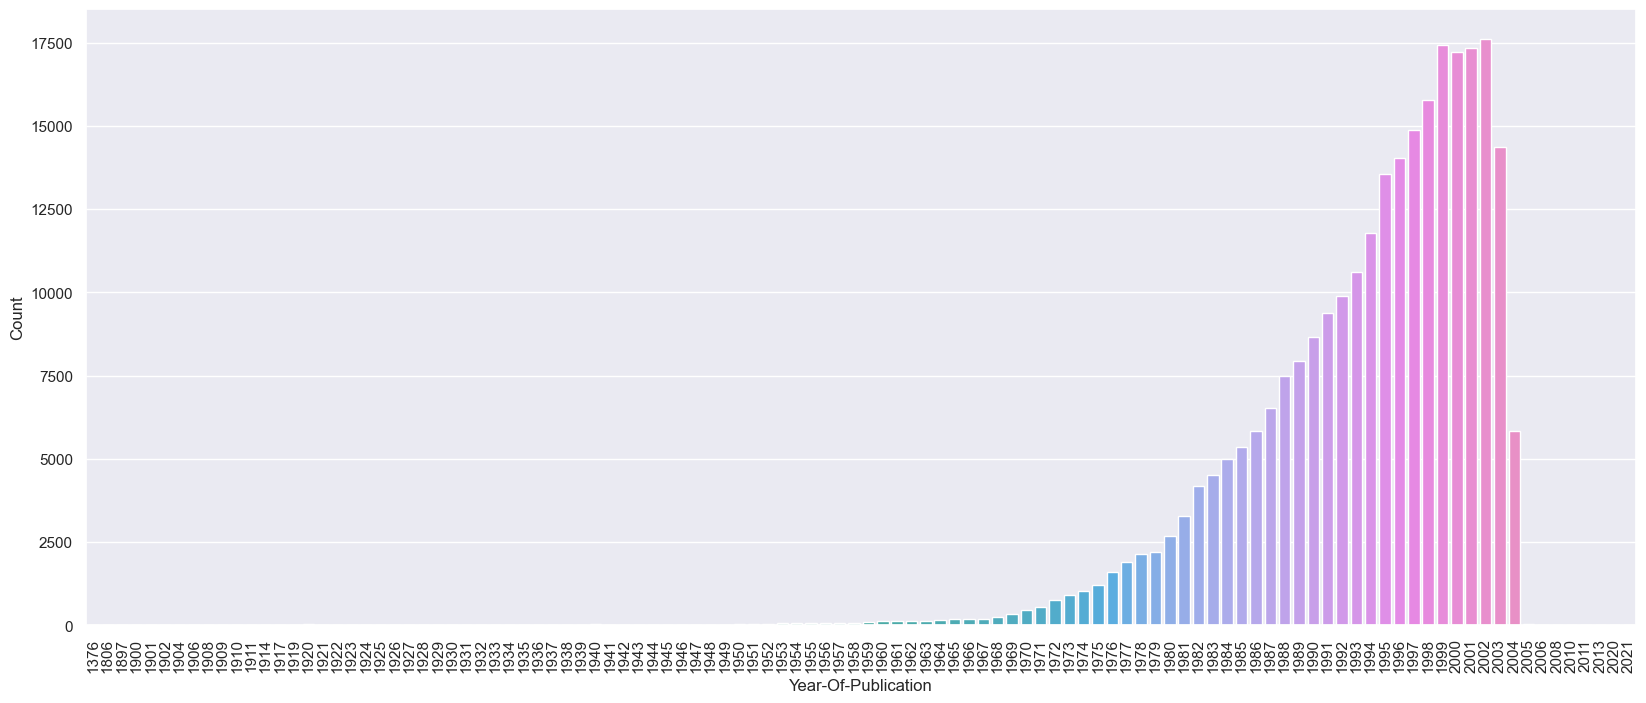

In [44]:
year_counts =  book[book['Year-Of-Publication'] != 0]['Year-Of-Publication'].value_counts().reset_index()
year_counts.columns = ['Year-Of-Publication', 'Count'] 
# Sorting the values by 'Year-Of-Publication'
year_counts = year_counts.sort_values('Year-Of-Publication')
# Setting the plot style
sns.set(rc={'figure.figsize':(20,8)})
# Creating the bar plot of the above obtained values
ax = sns.barplot(x=year_counts['Year-Of-Publication'], y=year_counts['Count'])
# Rotating x-axis labels for readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# Display the plot
plt.show()

We can observe that publication years range between 1950 and 2005. The publication of books became significant starting around 1950. The highest peak in book publications occurred between 1995 and 2001.

## Merging The Data

In [45]:
# Filter the ratings where ISBN is in the book dataset
filter_ratings = rating[rating['ISBN'].isin(book['ISBN'])]
filter_ratings

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149774,276704,0876044011,0
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10


<li>This line filters the rating DataFrame to include only rows where the ISBN exists in the book DataFrame. 
<li>This step ensures that only ratings for books that are present in the book dataset are kept.

In [46]:
bookrating = pd.merge(filter_ratings, book, on="ISBN")
bookrating.head(2)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...


<li>This merges the filtered filter_ratings DataFrame with the book DataFrame on the ISBN column. 
<li>The result, book_rating, combines book details with their corresponding ratings.

In [47]:
bookrating.shape

(1031126, 8)

### Filtering Duplicates Based on Highest Ratings for Each Book Title
I used a group-by operation on the Book-Title and selected the rows with the highest ratings for each title using idxmax. This allowed me to filter out the duplicates and keep only the rows with the highest rating for each book title.

In [48]:
book_rating = bookrating.groupby('Book-Title')['Book-Rating'].idxmax()
book_rating = bookrating.loc[book_rating]
book_rating.head(2)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
575113,96448,0590567330,9,A Light in the Storm: The Civil War Diary of ...,Karen Hesse,1999,Hyperion Books for Children,http://images.amazon.com/images/P/0590567330.0...
954569,172742,0964147726,0,Always Have Popsicles,Rebecca Harvin,1994,Rebecca L. Harvin,http://images.amazon.com/images/P/0964147726.0...


In [49]:
book_rating.shape

(241064, 8)

### Calculating Average
#### Why take average?
<li>Average ratings allow for easy comparisons between books. This helps to rank books based on their perceived quality and popularity, which can be particularly useful when recommending the top books to users.
<li>Individual ratings can be noisy due to extreme values (very high or low ratings) that may not reflect the general consensus. Averaging helps reduce the impact of these outliers, leading to a more balanced view of the book’s reception.

In [50]:
avg_rating =  book_rating.groupby('Book-Title')['Book-Rating'].mean().reset_index()
avg_rating.rename(columns={'Book-Rating':'Average-Rating'}, inplace=True)
avg_rating.head()

,Book-Title,Average-Rating
0,A Light in the Storm: The Civil War Diary of ...,9.0
1,Always Have Popsicles,0.0
2,Apple Magic (The Collector's series),0.0
3,"Ask Lily (Young Women of Faith: Lily Series, ...",8.0
4,Beyond IBM: Leadership Marketing and Finance ...,0.0


### Merge book_rating and average ratings

In [51]:
avgbook_ratings = pd.merge(book_rating, avg_rating, on='Book-Title')
avgbook_ratings.head(2)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,Average-Rating
0,96448,0590567330,9,A Light in the Storm: The Civil War Diary of ...,Karen Hesse,1999,Hyperion Books for Children,http://images.amazon.com/images/P/0590567330.0...,9.0
1,172742,0964147726,0,Always Have Popsicles,Rebecca Harvin,1994,Rebecca L. Harvin,http://images.amazon.com/images/P/0964147726.0...,0.0


The code merges book_rating with the avgdf DataFrame on the ISBN column. This step adds the average rating information to each record in book_rating

#### Observations
<li>The bulk of the average ratings are in the higher range (7.0 and above), with a particularly large concentration at 10.0 (37,012), followed by 8.0 (27,923), and 9.0 (21,548). This suggests that many books are generally well-received by readers.
<li>The dominance of these higher ratings indicates that users tend to rate books positively, which is common in rating systems as people are more likely to rate what they enjoy.
<li>Moderate average ratings are present but significantly fewer compared to higher ratings. Books in this range (5.0 and 6.0) might indicate mixed or average reception. However, they still receive more ratings than lower ranges, showing some level of engagement from readers.
<li>Ratings from 1.0 to 4.0 have relatively low counts, indicating that few books receive consistently low ratings. This could imply, Readers generally avoid rating books they strongly dislike, There might be a positive bias in the rating system where extreme low scores are less frequently given or shared, Books with consistently low ratings are less common or get filtered out over time.

In [52]:
avgbook_ratings['Average-Rating'].value_counts().sort_index(ascending=False)

Average-Rating
10.0     39309
9.0      22135
8.0      28220
7.0      18580
6.0       8595
5.0      14532
4.0       1936
3.0       1249
2.0        597
1.0        410
0.0     105501
Name: count, dtype: int64

### Calculate the Number of Ratings
#### Reasons to Calculate the Number of Ratings After Averaging:
<li>When ranking books, a book with a higher number of ratings might be ranked higher even if another book has a slightly higher average rating but fewer ratings. This approach often provides a better overall user experience, favoring books that are not only highly rated but also widely reviewed.
<li>A book with very few ratings is more susceptible to outliers (extremely high or low ratings) which can distort the average. A larger number of ratings generally indicates that the average is more robust and less influenced by any single extreme rating.

In [53]:
#num_rating=avgdf.groupby('Book-Title').count()['Book-Rating'].sort_values(ascending=False).reset_index()
#nonzero_rating = bookrating[bookrating['Book-Rating'] != 0]
num_rating = bookrating.groupby('Book-Title')['Book-Rating'].count().reset_index()
num_rating.rename(columns={'Book-Rating':'Number-of-Rating'}, inplace=True)
num_rating

,Book-Title,Number-of-Rating
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1
...,...,...
241059,Ã?Â?lpiraten.,2
241060,Ã?Â?rger mit Produkt X. Roman.,4
241061,Ã?Â?sterlich leben.,1
241062,Ã?Â?stlich der Berge.,3


### Merge average raings and number of ratings

In [54]:
numb_ratings = pd.merge(avgbook_ratings, num_rating, on='Book-Title')
numb_ratings.head(2)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,Average-Rating,Number-of-Rating
0,96448,0590567330,9,A Light in the Storm: The Civil War Diary of ...,Karen Hesse,1999,Hyperion Books for Children,http://images.amazon.com/images/P/0590567330.0...,9.0,4
1,172742,0964147726,0,Always Have Popsicles,Rebecca Harvin,1994,Rebecca L. Harvin,http://images.amazon.com/images/P/0964147726.0...,0.0,1


### Calculating the top 10% of most-rated books

In [55]:
threshold = numb_ratings['Number-of-Rating'].quantile(0.90)
# Filter books that have more than or equal to the threshold number of ratings
top_10_percent = numb_ratings[numb_ratings['Number-of-Rating'] >= threshold]

In [56]:
top_10_percent[(top_10_percent['Number-of-Rating'] >800)].sort_values(by='Number-of-Rating', ascending=True)[['Book-Title', 'Number-of-Rating', 'Average-Rating']]

,Book-Title,Number-of-Rating,Average-Rating
27918,Bridget Jones's Diary,815,10.0
199229,The Nanny Diaries: A Novel,828,10.0
5303,A Painted House,838,10.0
183565,The Da Vinci Code,898,10.0
196318,The Lovely Bones: A Novel,1295,10.0
234944,Wild Animus,2502,10.0


### Top Rated But Not Top Voted Books

In [57]:
top_ratings_not_votes = top_10_percent[(top_10_percent['Number-of-Rating'] <10) & (top_10_percent['Average-Rating'] == 10)].sort_values(by='Number-of-Rating', ascending=True)[['Book-Title', 'Number-of-Rating', 'Average-Rating']]
top_ratings_not_votes.head(10)

,Book-Title,Number-of-Rating,Average-Rating
128544,Never Kissed Goodnight,7,10.0
87884,Hunger of Memory : The Education of Richard Ro...,7,10.0
178955,The Books in My Life,7,10.0
179054,The Box Garden,7,10.0
179289,"The Bride Fair (Harlequin Historical, No. 603)",7,10.0
86926,"How to Host a Seduction (Harlequin Blaze, No 80)",7,10.0
179484,"The Brothers of Gwynedd: Comprising, Sunrise i...",7,10.0
179834,The California Book of the Dead: A Novel,7,10.0
85999,Household Hints and Handy Tips,7,10.0
85930,House of Illusions,7,10.0


### Top Voted Books But Not Top Rated 

In [58]:
top_votes_not_ratings = top_10_percent[(top_10_percent['Number-of-Rating'] >=100) & (top_10_percent['Average-Rating'] == 9)].sort_values(by='Number-of-Rating', ascending=True)[['Book-Title', 'Number-of-Rating', 'Average-Rating']]
top_votes_not_ratings

,Book-Title,Number-of-Rating,Average-Rating
194911,The Laws of Our Fathers,110,9.0
47728,Degree of Guilt,116,9.0
43490,Dances With Wolves,127,9.0
195583,The Little Friend,139,9.0
1266,4 Blondes,151,9.0
122643,Moo,159,9.0


<li>If you're noticing in both scenarios — where the Average-Rating is 10 and the Number-of-Ratings exceeds 300, and where many books have high ratings but a low number of votes<b>(like The California Book of the Dead: A Novel	 with an average rating of Average-Rating 10 but Number-of-Rating is 7)</b>, this can be problematic for ranking or recommending books because the ratings may not be representative due to the small sample size.
<li>This is where <b>weighted ratings</b> come into play, as they balance the average rating against the number of votes. Weighted ratings help avoid biasing the system in favor of books with very few but high ratings.

In [59]:
numb_ratings['Number-of-Rating'].value_counts()

Number-of-Rating
1      127507
2       42729
3       20254
4       11364
5        7530
        ...  
588         1
575         1
428         1
347         1
234         1
Name: count, Length: 377, dtype: int64

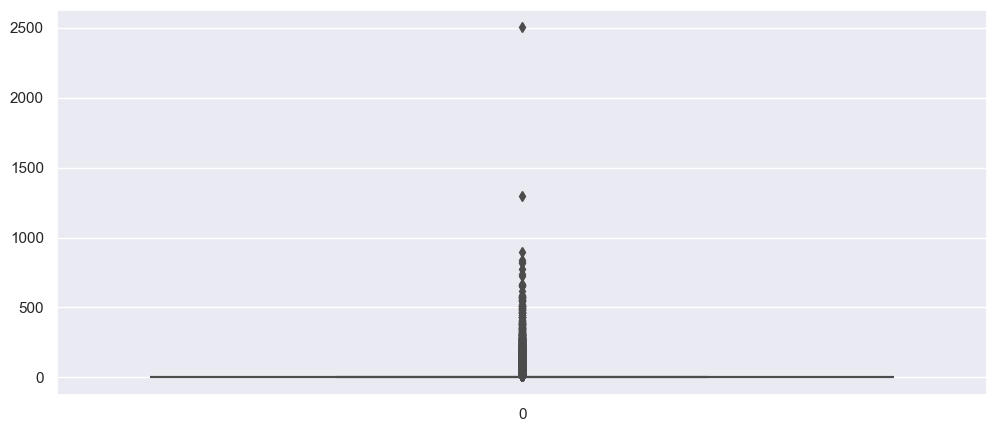

In [60]:
plt.figure(figsize=(12,5))
sns.boxplot(numb_ratings['Number-of-Rating'])
plt.show()

#### Observation:
<li>There is a significant imbalance, with the majority of books rated 1 (88,136) and very few books rated higher, particularly for ratings like 5 and below (2895 for 5, 4576 for 4). This sharp imbalance skews the dataset, making it difficult to model effectively. Additionally, there are numerous unique ratings with only one occurrence (e.g., ratings of 123, 336, and 212), which may indicate anomalies or outliers in the dataset that could distort the predictions of a recommendation system.


## Transforming the Data:
Given the imbalance in the ratings and the presence of potential outliers, applying a logarithmic transformation to the data helps to reduce the skewness and brings the distribution closer to a normal shape.

min_ratings_threshold = 10  # set a threshold
filtered_books = numb_ratings[(numb_ratings['Number-of-Rating'] >= 10) & (numb_ratings['Number-of-Rating'] <= 600)]
filtered_books.head()

In [61]:
number_ratings=numb_ratings.copy()

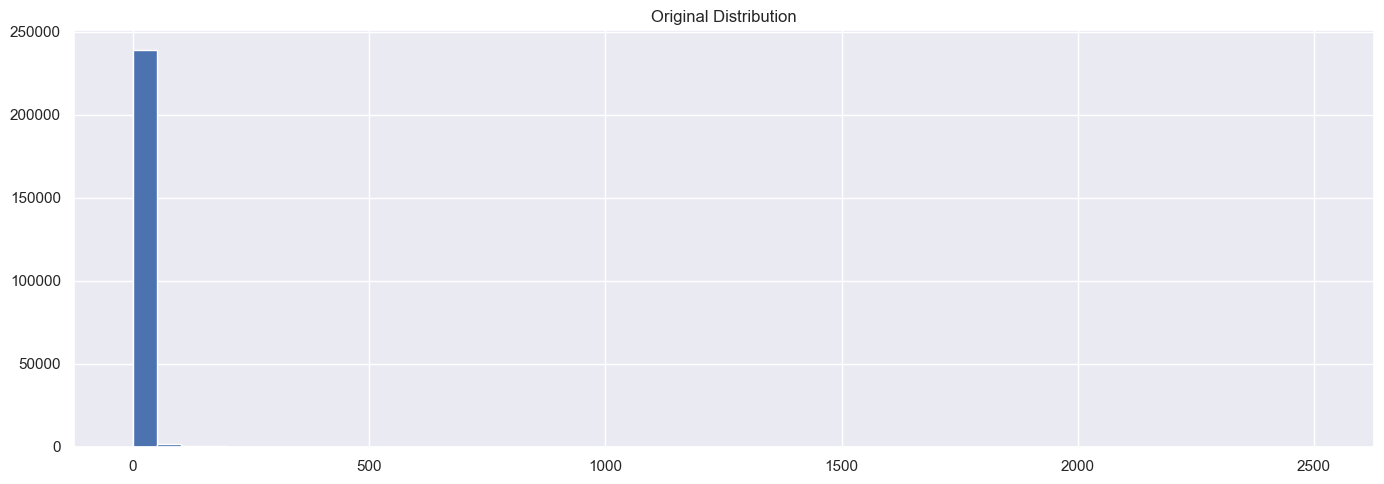

C:\Users\risha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


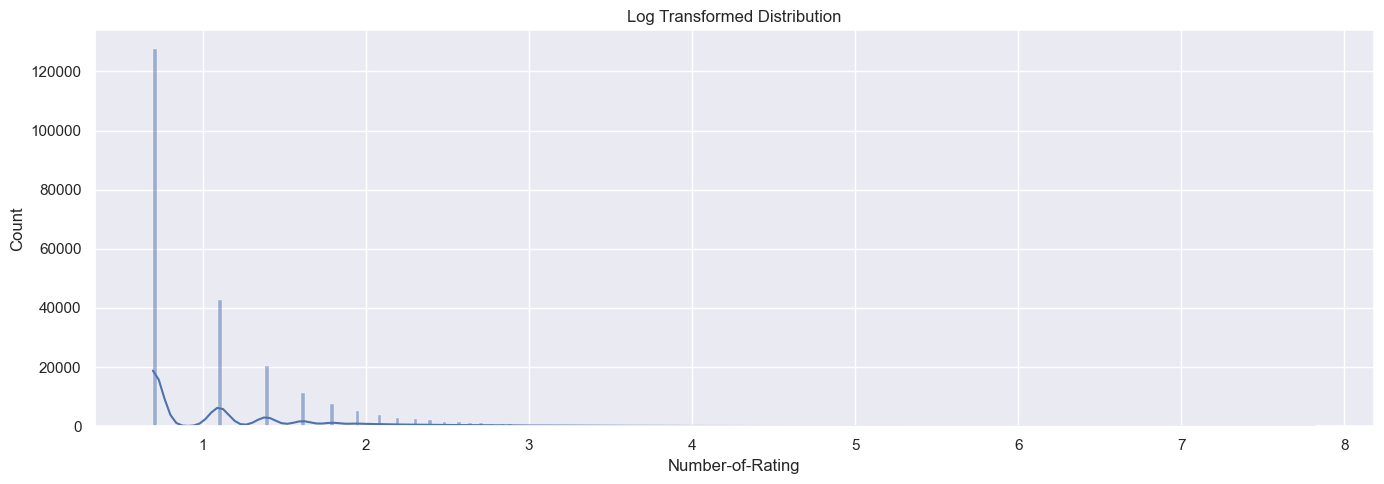

In [62]:
from scipy.stats import probplot, boxcox

plt.figure(figsize=(14, 5))
# Original Distribution and Q-Q Plot
plt.hist(numb_ratings['Number-of-Rating'], bins=50)
plt.title('Original Distribution')
plt.tight_layout()
plt.show()

# Log Transformation
number_ratings['Number-of-Rating'] = np.log1p(number_ratings['Number-of-Rating'])
plt.figure(figsize=(14, 5))
sns.histplot(number_ratings['Number-of-Rating'], kde=True)
plt.title('Log Transformed Distribution')
plt.tight_layout()
plt.show()

In [63]:
number_ratings = number_ratings[number_ratings['Number-of-Rating'] >= 1]
number_ratings['Number-of-Rating'] =number_ratings['Number-of-Rating'].astype(int)

In [64]:
number_ratings['Number-of-Rating'].value_counts()

Number-of-Rating
1    87173
2    18776
3     5389
4     1722
5      434
6       61
7        2
Name: count, dtype: int64

In [65]:
number_ratings.head(2)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,Average-Rating,Number-of-Rating
0,96448,0590567330,9,A Light in the Storm: The Civil War Diary of ...,Karen Hesse,1999,Hyperion Books for Children,http://images.amazon.com/images/P/0590567330.0...,9.0,1
7,170595,0786000015,0,Deceived,Carla Simpson,1994,Pinnacle Books,http://images.amazon.com/images/P/0786000015.0...,0.0,1


In [66]:
number_ratings.shape

(113557, 10)

### Calculate the weighted rating of a book

Where:
<li>WR = Weighted Rating
<li>R = Average rating for the book (mean rating)
<li>v = Number of votes (ratings) for the book
<li>m = Minimum number of votes required to be considered
<li>C = The mean (average) rating across the entire dataset


In [67]:
C = number_ratings['Average-Rating'].mean()

# Define minimum number of ratings required for consideration
m = number_ratings['Number-of-Rating'].quantile(0.95)

# Function to calculate weighted rating
def weighted_rating(row, C, m):
    v = row['Number-of-Rating']    # Number of ratings for the book
    R = row['Average-Rating']      # Average rating for the book
    return ((R * v) + (C * m)) / (v + m)

# Apply the weighted rating function to the dataset
number_ratings['Weighted-Rating'] = number_ratings.apply(weighted_rating, axis=1, C=C, m=m)

In [68]:
m

3.0

In [69]:
number_ratings.head(2)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,Average-Rating,Number-of-Rating,Weighted-Rating
0,96448,0590567330,9,A Light in the Storm: The Civil War Diary of ...,Karen Hesse,1999,Hyperion Books for Children,http://images.amazon.com/images/P/0590567330.0...,9.0,1,6.782118
7,170595,0786000015,0,Deceived,Carla Simpson,1994,Pinnacle Books,http://images.amazon.com/images/P/0786000015.0...,0.0,1,4.532118


In [70]:
number_ratings.shape

(113557, 11)

# 1) Popularity Based Recommendation System

In [71]:
book_ratings_above_6 = number_ratings[number_ratings['Number-of-Rating'] >= 6]
book_ratings_above_6 = book_ratings_above_6[['User-ID', 'Book-Title', 'Average-Rating', 'Number-of-Rating', 'Weighted-Rating']]
book_ratings_above_6 = book_ratings_above_6.sort_values(by='Average-Rating', ascending=False)
book_ratings_above_6.head()

,User-ID,Book-Title,Average-Rating,Number-of-Rating,Weighted-Rating
818,278535,1st to Die: A Novel,10.0,6,8.680941
202236,22625,The Pilot's Wife : A Novel,10.0,6,8.680941
187694,9484,The Firm,10.0,6,8.680941
187872,1848,The Five People You Meet in Heaven,10.0,6,8.680941
189258,147686,The Girls' Guide to Hunting and Fishing,10.0,6,8.680941


In [72]:
book_ratings_above_6.shape

(63, 5)

In [73]:
final_books=pd.merge(book_ratings_above_6,book, on='Book-Title').drop_duplicates('Book-Title',keep='first')
final_books.sort_values('Weighted-Rating', ascending=False).head(2)

,User-ID,Book-Title,Average-Rating,Number-of-Rating,Weighted-Rating,ISBN,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
267,12272,Wild Animus,10.0,7,8.812847,0971880107,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...
27,638,The Lovely Bones: A Novel,10.0,7,8.812847,0316666343,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...


# Data Visualizations
#### High rated books

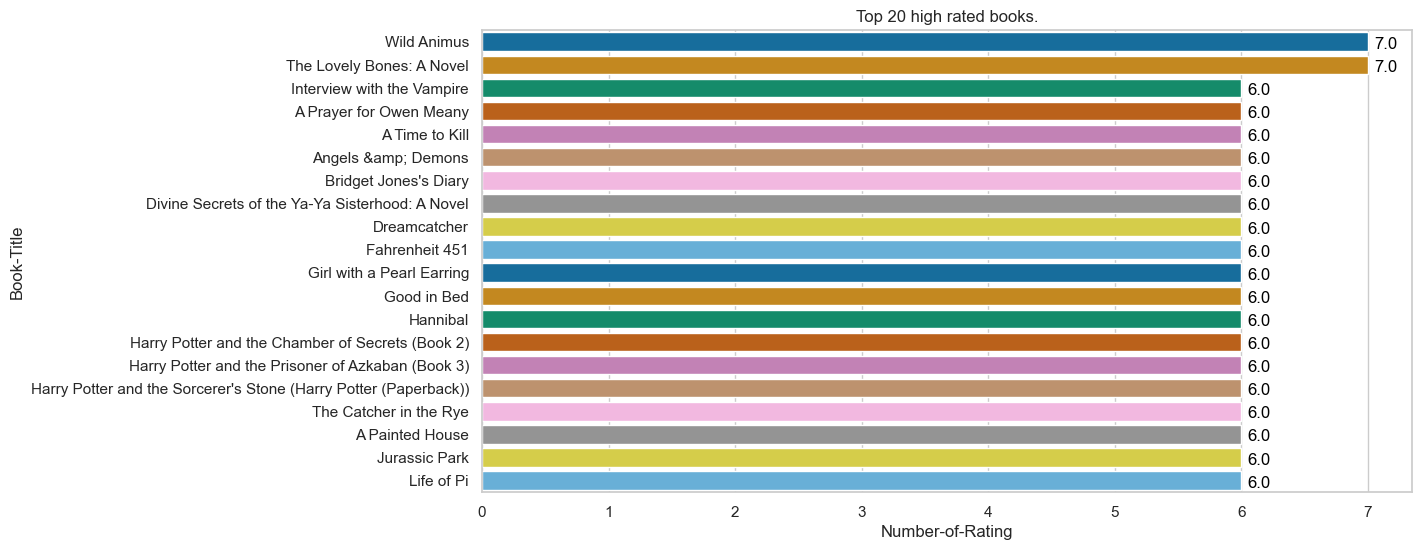

In [74]:
top_books = final_books.sort_values(by='Number-of-Rating', ascending=False).head(20)

sns.set(style='whitegrid')
plt.figure(figsize=(12,6))
color = sns.color_palette('colorblind')
ax = sns.barplot(x='Number-of-Rating', y='Book-Title', data=top_books, palette=color)

for i in ax.patches:
    ax.text(i.get_width() + 0.05, i.get_y() + 0.5, f'{i.get_width():.1f}', 
            fontsize=12, color='black', va='center')

plt.title('Top 20 high rated books.')
plt.show()

#### Authors with Most Ratings

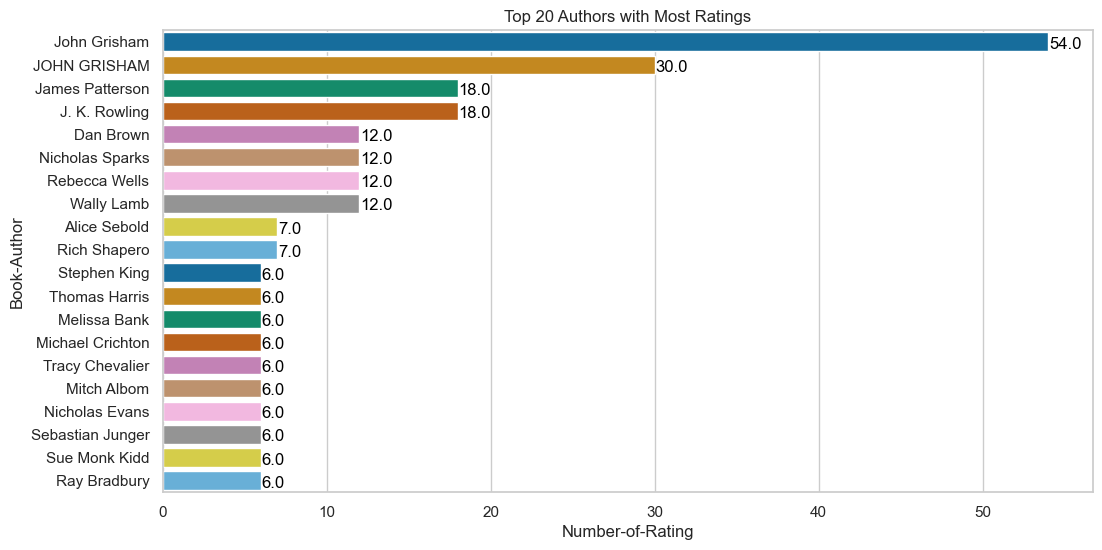

In [75]:
author_ratings = final_books.groupby('Book-Author')['Number-of-Rating'].sum().reset_index()
top_authors = author_ratings.sort_values(by='Number-of-Rating', ascending=False).head(20)

sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))
color = sns.color_palette('colorblind')
ax=sns.barplot(x='Number-of-Rating', y='Book-Author', data=top_authors, palette=color)

for i in ax.patches:
    ax.text(i.get_width() + 0.05, i.get_y() + 0.5, f'{i.get_width():.1f}', 
            fontsize=12, color='black', va='center')

plt.title('Top 20 Authors with Most Ratings')
plt.show()

#### Publisher with Most Ratings

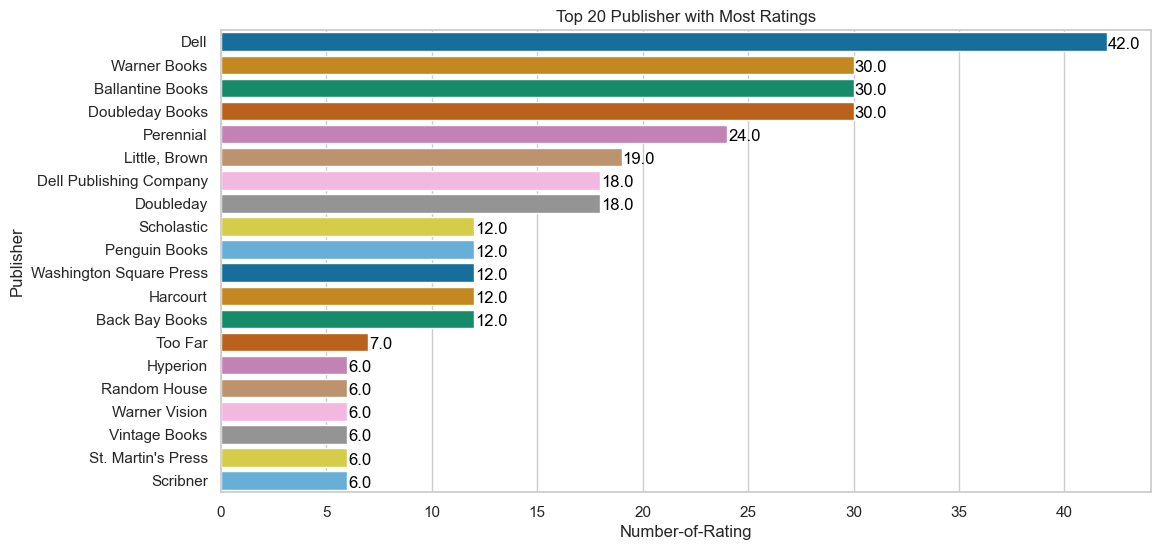

In [76]:
author_ratings = final_books.groupby('Publisher')['Number-of-Rating'].sum().reset_index()
top_authors = author_ratings.sort_values(by='Number-of-Rating', ascending=False).head(20)

sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))
color = sns.color_palette('colorblind')
ax=sns.barplot(x='Number-of-Rating', y='Publisher', data=top_authors, palette=color)

for i in ax.patches:
    ax.text(i.get_width() + 0.05, i.get_y() + 0.5, f'{i.get_width():.1f}', 
            fontsize=12, color='black', va='center')

plt.title('Top 20 Publisher with Most Ratings')
plt.show()

# 2. Collaborative Filtering 
Technique used in recommendation systems to predict a user’s preference for an item based on preferences of similar users or similar items. It leverages past behavior and interactions to make personalized suggestions. There are two main types of collaborative filtering:
#### Memory-based:
<li>User-based: Find users similar to the target user and recommend items they liked.
<li>Item-based: Find items similar to those the target user liked and recommend them.
    
#### Model-based:
<li>Involves training a machine learning model to predict missing values in the user-item matrix.
<li>Techniques like matrix factorization (e.g., SVD, Alternating Least Squares) and neural collaborative filtering are commonly used here.
    
## 1. User-based Collaborative Filtering:
This approach recommends items to a user based on the preferences of similar users. It assumes that if user A has a similar taste to user B, then items liked by user B but not yet rated or consumed by user A can be recommended to user A.    
<li><b>Example:</b>If User A and User B both rate certain movies highly, and User A has watched a movie that User B hasn’t, that movie is recommended to User B. 
    
## 2. Item-based Collaborative Filtering:
This approach recommends items that are similar to items a user has already interacted with. It assumes that if a user liked item A, they are likely to enjoy items similar to A.
<li><b>Example:</b>If a user enjoys a particular movie, the system will recommend movies that have similar attributes or have been rated highly by others who enjoyed that same movie.


# Item-based Collaborative Filtering
For an item-item based collaborative filtering recommendation system, there are multiple approaches, each with its strengths depending on the data and requirements
### 1. k-Nearest Neighbors (k-NN)
<li><b>Advantages:</b>Easy to implement and interpret, Finds the most similar items based on their ratings.
<li><b>Disadvantages:</b>Can be computationally expensive for large datasets, Does not handle sparsity well in its basic form.

### 2. Cosine Similarity
What it is: Measures the cosine of the angle between two vectors (items in this case). It captures the directional similarity between item ratings.
<li><b>Advantages:</b>Works well with sparse data, Commonly used in collaborative filtering systems. It focuses on the similarity in terms of the shape of the rating patterns, not their magnitudes.

### 3. Pearson Correlation Coefficient
What it is: Measures the linear correlation between two variables, in this case, the ratings of two items. It captures how well the ratings of one item move with another.
<li><b>Advantages:</b>Can handle different rating scales better than cosine similarity (e.g., a user might rate one item 5 and another 4, which still indicates similarity).

### 4. Matrix Factorization (e.g., SVD, ALS)
What it is: Reduces the dimensionality of the user-item matrix, extracting latent features that explain the patterns of ratings. This technique is often more accurate than neighborhood-based methods.
<li><b>Advantages:</b>Works well for large datasets, Captures hidden relationships and patterns that are not directly visible from the rating data.
<li><b>Disadvantages:</b>More complex to implement, Requires careful tuning of hyperparameters.

### Which Approach is Best?
<li><b>Cosine Similarity:</b> If you're looking for simplicity and performance on large, sparse datasets, this is often the best choice. It is widely used in recommendation systems and provides solid results without being too computationally expensive.
<li><b>k-Nearest Neighbors (k-NN):</b> Good for small datasets but can become computationally heavy for large datasets.
<li><b>Pearson Correlation:</b> Effective if you want to capture more complex relationships between items, but can be slower than cosine similarity.
<li><b>Matrix Factorization (SVD):</b> Best for large-scale recommendation systems that require advanced, fine-tuned accuracy, but is more complex to implement and tune.

In [77]:
it_based_book = number_ratings[number_ratings['Number-of-Rating'] >= 5]
it_based_book = it_based_book.sort_values(by='Average-Rating', ascending=False)
it_based_book.head(2)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,Average-Rating,Number-of-Rating,Weighted-Rating
764,1706,0451524934,10,1984,George Orwell,1990,Signet Book,http://images.amazon.com/images/P/0451524934.0...,10.0,5,8.516059
178257,120701,0385475721,10,The Blind Assassin,Margaret Atwood,2000,Nan A. Talese,http://images.amazon.com/images/P/0385475721.0...,10.0,5,8.516059


In [78]:
it_based_book.shape

(497, 11)

In [79]:
book_pivot = it_based_book.pivot_table(index='Book-Title',columns='User-ID', values='Book-Rating')
book_pivot.fillna(0, inplace=True)
book_pivot.head()

User-ID,125,254,388,503,507,595,638,709,763,778,882,915,1021,1022,1309,1435,1608,1650,1674,1706,1768,1848,1903,2010,2012,2030,2033,2139,2276,2288,2528,3166,3305,3331,3363,3371,3373,3543,3556,3578,3596,3709,3827,4017,4365,4622,4795,4938,4999,5034,5037,5048,5268,5385,5499,5539,5582,5850,6115,6135,6238,6251,6345,6431,6543,6563,6611,6637,6679,6768,6789,6900,7079,7105,7158,7194,7248,7283,7412,7887,7915,8067,8086,8089,8234,8253,8454,8801,8839,8937,9139,9314,9354,9484,9605,9728,9747,9856,10118,10153,10447,10643,11400,11601,11676,11944,12194,12272,12316,12589,12685,12707,12784,12917,12926,13080,13432,13503,13551,13552,13709,13850,14045,14454,14521,14546,15369,15408,15602,15651,16246,16504,16532,16718,16736,16795,16916,17003,17190,17402,17859,18096,18908,19085,19107,19259,19573,20060,20119,20172,20180,20254,20916,21031,21370,21618,21909,22045,22495,22625,22936,23020,23511,23680,24926,24960,25062,25109,25129,25409,25533,25981,26192,26406,26593,28177,28619,28634,29209,29526,30081,30245,30495,30735,30939,31116,31315,31391,31826,31980,32101,32154,32244,32250,32516,32964,33818,33967,34526,35238,35842,35931,36554,37227,37511,37597,37950,38023,38326,38356,38544,38789,38950,39227,39773,40012,40318,40732,40889,41013,41117,42651,43359,43842,45078,45107,47201,47316,48494,49460,49761,49771,50509,51207,51350,51450,51545,51883,52011,52159,52584,53392,53414,53978,54283,54429,56611,56632,56661,57095,57105,57959,58672,59172,59269,60244,60621,61917,62929,63993,64875,65068,65484,71587,74056,75591,76151,76890,78834,82936,83287,85750,87051,88229,88693,89091,91113,91491,92405,92569,95359,96388,97754,98904,101214,104278,105221,106849,107616,109620,110029,111847,112001,114368,117251,117384,120701,125878,131290,135043,136561,137971,143175,147224,147686,159977,163358,165308,165345,168055,170064,179791,182442,184632,196106,196821,208897,215948,223872,237407,268786,276788,276822,276896,276925,276953,277051,277179,277195,277235,277246,277427,277462,277523,277722,277911,277922,277959,277965,277984,278122,278162,278333,278356,278487,278535,278582,278633,278807,278832
Book-Title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [80]:
book_pivot

User-ID,125,254,388,503,507,595,638,709,763,778,882,915,1021,1022,1309,1435,1608,1650,1674,1706,1768,1848,1903,2010,2012,2030,2033,2139,2276,2288,2528,3166,3305,3331,3363,3371,3373,3543,3556,3578,3596,3709,3827,4017,4365,4622,4795,4938,4999,5034,5037,5048,5268,5385,5499,5539,5582,5850,6115,6135,6238,6251,6345,6431,6543,6563,6611,6637,6679,6768,6789,6900,7079,7105,7158,7194,7248,7283,7412,7887,7915,8067,8086,8089,8234,8253,8454,8801,8839,8937,9139,9314,9354,9484,9605,9728,9747,9856,10118,10153,10447,10643,11400,11601,11676,11944,12194,12272,12316,12589,12685,12707,12784,12917,12926,13080,13432,13503,13551,13552,13709,13850,14045,14454,14521,14546,15369,15408,15602,15651,16246,16504,16532,16718,16736,16795,16916,17003,17190,17402,17859,18096,18908,19085,19107,19259,19573,20060,20119,20172,20180,20254,20916,21031,21370,21618,21909,22045,22495,22625,22936,23020,23511,23680,24926,24960,25062,25109,25129,25409,25533,25981,26192,26406,26593,28177,28619,28634,29209,29526,30081,30245,30495,30735,30939,31116,31315,31391,31826,31980,32101,32154,32244,32250,32516,32964,33818,33967,34526,35238,35842,35931,36554,37227,37511,37597,37950,38023,38326,38356,38544,38789,38950,39227,39773,40012,40318,40732,40889,41013,41117,42651,43359,43842,45078,45107,47201,47316,48494,49460,49761,49771,50509,51207,51350,51450,51545,51883,52011,52159,52584,53392,53414,53978,54283,54429,56611,56632,56661,57095,57105,57959,58672,59172,59269,60244,60621,61917,62929,63993,64875,65068,65484,71587,74056,75591,76151,76890,78834,82936,83287,85750,87051,88229,88693,89091,91113,91491,92405,92569,95359,96388,97754,98904,101214,104278,105221,106849,107616,109620,110029,111847,112001,114368,117251,117384,120701,125878,131290,135043,136561,137971,143175,147224,147686,159977,163358,165308,165345,168055,170064,179791,182442,184632,196106,196821,208897,215948,223872,237407,268786,276788,276822,276896,276925,276953,277051,277179,277195,277235,277246,277427,277462,277523,277722,277911,277922,277959,277965,277984,278122,278162,278333,278356,278487,278535,278582,278633,278807,278832
Book-Title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [81]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity between items
cosine_sim = cosine_similarity(book_pivot)

# Convert cosine similarity result into a DataFrame for easier access
cosine_sim_df = pd.DataFrame(cosine_sim, index=book_pivot.index, columns=book_pivot.index)

In [82]:
# Function to get top N similar books
def get_similar_books(book_name, N=5):
    similar_books = cosine_sim_df[book_name].sort_values(ascending=False).iloc[1:N+1]
    return similar_books

In [83]:
def get_similar_books(book_name, N=5):
    # Ensure the book exists in the dataset
    if book_name not in cosine_sim_df.index:
        return f"'{book_name}' not found in the dataset."
    
    similar_books = cosine_sim_df[book_name].sort_values(ascending=False).iloc[1:N+1]
    
    return similar_books.index.tolist()

In [84]:
get_similar_books('Harry Potter and the Goblet of Fire (Book 4)')

['Harry Potter and the Order of the Phoenix (Book 5)',
 'Harry Potter and the Prisoner of Azkaban (Book 3)',
 'The Bluest Eye',
 'The Celestine Prophecy (Celestine Prophecy)',
 'The Catcher in the Rye']

In [85]:
get_similar_books('1st to Die: A Novel')

['Roses Are Red (Alex Cross Novels)',
 "Suzanne's Diary for Nicholas",
 'The Blue Nowhere : A Novel',
 'The Celestine Prophecy (Celestine Prophecy)',
 'The Catcher in the Rye']

In [86]:
get_similar_books('Year of Wonders')

['Year of Wonders',
 'River, Cross My Heart',
 "The Pilot's Wife : A Novel",
 'The Bourne Identity',
 'The Body Farm']

# User-based Collaborative Filtering

In [87]:
userItemRatingMatrix=pd.pivot_table(it_based_book, values='Book-Rating',index=['User-ID'],
                                    columns=['Book-Title'])
userItemRatingMatrix.fillna(0, inplace=True)
userItemRatingMatrix.head()

Book-Title,1984,1st to Die: A Novel,2nd Chance,4 Blondes,A Bend in the Road,A Case of Need,"A Child Called \It\"": One Child's Courage to Survive""",A Civil Action,A Fine Balance,A Heartbreaking Work of Staggering Genius,A Is for Alibi (Kinsey Millhone Mysteries (Paperback)),A Lesson Before Dying (Vintage Contemporaries (Paperback)),A Man in Full,A Map of the World,A Painted House,A Patchwork Planet,A Prayer for Owen Meany,A Thousand Acres (Ballantine Reader's Circle),A Time to Kill,A Virtuous Woman (Oprah's Book Club (Paperback)),A Walk in the Woods: Rediscovering America on the Appalachian Trail (Official Guides to the Appalachian Trail),A Walk to Remember,A Widow for One Year,A Wrinkle In Time,A Wrinkle in Time,A Year in Provence,ANGELA'S ASHES,About a Boy,Absolute Power,Airframe,All Around the Town,All I Really Need to Know,All That Remains (Kay Scarpetta Mysteries (Paperback)),Along Came a Spider (Alex Cross Novels),American Gods,Angela's Ashes (MMP) : A Memoir,Angela's Ashes: A Memoir,Angels,Angels &amp; Demons,Animal Dreams,Animal Farm,Anne of Green Gables (Anne of Green Gables Novels (Paperback)),"Artemis Fowl (Artemis Fowl, Book 1)",Ashes to Ashes,At Home in Mitford (The Mitford Years),Atonement : A Novel,B Is for Burglar (Kinsey Millhone Mysteries (Paperback)),Back Roads,Bag of Bones,Balzac and the Little Chinese Seamstress : A Novel,Bastard Out of Carolina,Beach Music,Bee Season: A Novel,Before I Say Good-Bye,Bel Canto: A Novel,Beloved,Beloved (Plume Contemporary Fiction),Big Stone Gap: A Novel (Ballantine Reader's Circle),Big Trouble,Black House,Black Notice,Black and Blue,Bleachers,Blessings,Body of Lies,Brave New World,"Breath, Eyes, Memory",Breathing Lessons,Bridget Jones's Diary,Bridget Jones: The Edge of Reason,By the Light of the Moon,C Is for Corpse (Kinsey Millhone Mysteries (Paperback)),Call of the Wild,Carolina Moon,Cat &amp; Mouse (Alex Cross Novels),Cause of Death,Charming Billy,Chicken Soup for the Soul (Chicken Soup for the Soul),Chocolat,Choke,Chosen Prey,Circle of Friends,Clear and Present Danger (Jack Ryan Novels),Code to Zero,Cold Mountain,Cold Mountain : A Novel,Cold Sassy Tree,Confessions of a Shopaholic (Summer Display Opportunity),Confessions of an Ugly Stepsister : A Novel,Congo,Contact,Coraline,Couplehood,Cradle and All,Cruel &amp; Unusual (Kay Scarpetta Mysteries (Paperback)),D Is for Deadbeat (Kinsey Millhone Mysteries (Paperback)),Daddy's Little Girl,Daisy Fay and the Miracle Man,Dance upon the Air (Three Sisters Island Trilogy),Death du Jour,Debt of Honor (Jack Ryan Novels),Deception Point,Deja Dead,Desperation,Digital Fortress : A Thriller,Disclosure,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Dolores Claiborne,Don't Stand Too Close to a Naked Man,Don't Sweat the Small Stuff and It's All Small Stuff : Simple Ways to Keep the Little Things from Taking Over Your Life (Don't Sweat the Small Stuff Series),Dragonfly in Amber,Dreamcatcher,Drowning Ruth,Drowning Ruth (Oprah's Book Club),"Dude, Where's My Country?",Dust to Dust,E Is for Evidence: A Kinsey Millhone Mystery (Kinsey Millhone Mysteries (Paperback)),Easy Prey,Ellen Foster,Empire Falls,Ender's Game (Ender Wiggins Saga (Paperback)),Envy,Evening Class,Everything's Eventual : 14 Dark Tales,F Is for Fugitive (Kinsey Millhone Mysteries (Paperback)),Face the Fire (Three Sisters Island Trilogy),Fahrenheit 451,Faking It,Fall On Your Knees (Oprah #45),Falling Angels,False Memory,Fast Food Nation: The Dark Side of the All-American Meal,Fast Women,Fear Nothing,Final Target,Five Quarters of the Orange,Flesh and Blood,Fortune's Rocks : A Novel,Foucault's Pendulum,Four Blind Mice,Four Past Midnight,Four To Score (A Stephanie Plum Novel),Fried Green Tomatoes at the Whistle Stop Cafe,From Potter's Field,From the Corner of His Eye,Full House (Janet Evanovich's Full Series),Full Tilt (Janet Evanovich's Full Series),G Is for Gumshoe (Kinsey Millhone Mysteries (Paperback)),Gerald's Game,Girl in Hyacinth Blue,Girl with a Pearl Earring,"Girl, Interrup

In [88]:
user_ratings_mean = userItemRatingMatrix.mean(axis=1)
user_ratings_demeaned = userItemRatingMatrix.sub(user_ratings_mean, axis=0)

# Step 2: Calculate User Similarity Matrix based on demeaned ratings
user_similarity = cosine_similarity(user_ratings_demeaned.fillna(0))
user_similarity_df = pd.DataFrame(user_similarity, index=userItemRatingMatrix.index, columns=userItemRatingMatrix.index)

# Function to find a user's favorite books
def favoritebook(user_id, num_books=5):
    user_ratings = userItemRatingMatrix.loc[user_id]
    favorite_books = user_ratings[user_ratings > 0].sort_values(ascending=False).head(num_books)
    return favorite_books.index.tolist()

# Function to get top N recommendations for a user based on similar users
def topNRecommendations(user_id, n=5, num_similar_users=10):
    # Get top similar users, excluding the active user
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).iloc[1:num_similar_users + 1]
    
    # Get ratings of similar users, weighted by similarity
    similar_users_ratings = userItemRatingMatrix.loc[similar_users.index]
    weighted_ratings = similar_users_ratings.T.dot(similar_users) / similar_users.sum()
    
    # Find books the active user has not rated
    user_unrated_books = userItemRatingMatrix.loc[user_id] == 0
    recommendations = weighted_ratings[user_unrated_books]
    
    # Exclude favorite books from recommendations
    favorite_books = favoritebook(user_id, num_books=5)
    recommendations = recommendations[~recommendations.index.isin(favorite_books)]
    
    # Return top N book recommendations
    top_recommendations = recommendations.sort_values(ascending=False).head(n)
    return top_recommendations.index.tolist()

# Test the recommendation system for an active user
activeUser = 3363
print(f"Most favourite books of user {activeUser}:\nBooks: {favoritebook(activeUser, 5)}")
topNRecommendations(activeUser, 5)

Most favourite books of user 3363:
Books: ['Lucky : A Memoir']


['Ladder of Years',
 'Love in the Time of Cholera (Penguin Great Books of the 20th Century)',
 'Kiss the Girls',
 "Left Behind: A Novel of the Earth's Last Days (Left Behind No. 1)",
 'Jemima J: A Novel About Ugly Ducklings and Swans']

In [89]:
activeUser = 507
print(f"Most favourite books of user {activeUser}:\nBooks: {favoritebook(activeUser, 5)}")
topNRecommendations(activeUser, 5)

Most favourite books of user 507:
Books: ['The Secret Life of Bees']


['The Saving Graces: A Novel',
 'The Rainmaker',
 'The Pillars of the Earth',
 'The Rescue',
 'Pigs in Heaven']

In [90]:
activeUser = 125
print(f"Most favourite books of user {activeUser}:\nBooks: {favoritebook(activeUser, 5)}")
topNRecommendations(activeUser, 5)

Most favourite books of user 125:
Books: ['Midnight in the Garden of Good and Evil: A Savannah Story']


['Lucky : A Memoir',
 '1984',
 'Isle of Dogs',
 'Life of Pi',
 'The Secret Life of Bees']

In [1]:
pip install scikit-surprise

  Using cached scikit_surprise-1.1.4.tar.gz (154 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build scikit-surprise
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  exit code: 1
  
  [115 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build\lib.win-amd64-cpython-311\surprise
  copying surprise\accuracy.py -> build\lib.win-amd64-cpython-311\surprise
  copying surprise\builtin_datasets.py -> build\lib.win-amd64-cpython-311\surprise
  copying surprise\dataset.py -> build\lib.win-amd64-cpython-311\surprise
  copying surprise\dump.py -> build\lib.win-amd64-cpython-311\surprise
  copying surprise\reader.py -> build\lib.win-amd64-cpython-311\surprise
  copying surprise\trainset.py -> build\lib.win-amd64-cpython-311\surprise
  copying surprise\utils.py -> build\lib.win-amd64-cpython-311\surprise
  copying surprise\__init__.py -> build\lib.win-amd64-cpython-311\surprise
  copying surprise\__main__.py -> build\lib.win-amd64-cpython-311\surprise
  creating build\lib.win-amd64-cpython-311\surprise\model_selection
  copying surprise\model_selection\search.py -> build\lib.win-amd64

In [1]:
pip install scikit-surprise --only-binary :all:

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement scikit-surprise (from versions: none)
ERROR: No matching distribution found for scikit-surprise
